In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
DATA_FOLDER = "/content/drive/MyDrive/Random/Hiroshima/ABC2025/Test"

# 训练 ID
USER_IDS = ["T1N01", "T1F01", "T1S01", "T1S02"]
# 测试 ID
TEST_IDS = ["T1N02", "T1F02"]

FS = 33  # Sampling rate

# 动作标签 -> ID
action_mapping = {
    "Explanation to patient": 0,
    "Confirm necessary items": 1,
    "Disinfect hands": 2,
    "Wearing gloves": 3,
    "Prepare the nutrition solution": 4,
    "Check the gastrostomy site": 5,
    "Open the gastrostomy cap": 6,
    "Inject lukewarm water": 7,
    "Connect the nutrition tube": 8,
    "Adjust the infusion rate": 9,
    "Removal of gloves": 10,
    "Prepare lukewarm water": 11,
    "Close the clamp": 12,
    "Disconnect the nutrition tube": 13,
    "Close the gastrostomy cap": 14,
    "Clean up used items": 15,
    "Others": 16
}


In [4]:
def load_data(user_ids, data_folder=DATA_FOLDER):
    all_kp_data = []
    all_ann_data= []
    for user_id in user_ids:
        keypoint_csv = f"{data_folder}/Body_KeyPoint_CSV/Front_{user_id}.csv"
        ann_csv      = f"{data_folder}/Annotation_CSV/Front_{user_id}.csv"
        kp_df_raw  = pd.read_csv(keypoint_csv)
        ann_df_raw = pd.read_csv(ann_csv)

        kp_df= kp_df_raw.loc[:, ~kp_df_raw.columns.str.contains('^Unnamed')]
        ann_df= ann_df_raw.loc[:, ~ann_df_raw.columns.str.contains('^Unnamed')]

        # 删除部分关节点 (膝盖/脚踝等)
        kp_df= kp_df.loc[:, ~kp_df.columns.str.contains('Frame|conf|left_knee|right_knee|left_ankle|right_ankle', regex=True)]

        all_kp_data.append(kp_df)
        all_ann_data.append(ann_df)
    return all_kp_data, all_ann_data

print("Loading training data...")
all_kp_data, all_ann_data= load_data(USER_IDS)
print("Loading testing data...")
test_all_kp_data, test_all_ann_data= load_data(TEST_IDS)
print("Data loaded successfully!")

Loading training data...
Loading testing data...
Data loaded successfully!


In [5]:
SMOOTH_LEN= 3

def smooth_kp(kp_col, fs=FS, smooth_len=SMOOTH_LEN):
    zero_idx= np.flatnonzero(kp_col==0)
    split_idx= np.split(zero_idx, np.flatnonzero(np.diff(zero_idx)>1)+1)
    for each_split_idx in split_idx:
        if (len(each_split_idx)==0
            or each_split_idx[0]==0
            or each_split_idx[-1]==(len(kp_col)-1)
            or len(each_split_idx)> smooth_len*fs):
            continue
        xp= [each_split_idx[0]-1, each_split_idx[-1]+1]
        fp= kp_col[xp]
        interp_kp= np.interp(each_split_idx, xp, fp)
        kp_col[each_split_idx]= interp_kp
    return kp_col

def smooth_all_data(all_kp_data):
    for kp_df in all_kp_data:
        for col in kp_df.columns:
            kp_df[col]= smooth_kp(np.array(kp_df[col]))
    return all_kp_data

print("Smoothing training data...")
all_kp_data= smooth_all_data(all_kp_data)
print("Smoothing testing data...")
test_all_kp_data= smooth_all_data(test_all_kp_data)
print("All data smoothed!")

Smoothing training data...
Smoothing testing data...
All data smoothed!


In [6]:
for ann_df in all_ann_data:
    ann_df["activityID"]= ann_df["annotation"].map(action_mapping)
for ann_df in test_all_ann_data:
    ann_df["activityID"]= ann_df["annotation"].map(action_mapping)
print("Mapped activity labels to activity IDs.")


Mapped activity labels to activity IDs.


In [7]:
WINDOW_SIZE=2
OVERLAP_RATE=0.5*WINDOW_SIZE

def segment(data, max_time, sub_window_size, stride_size):
    sub_windows= np.arange(sub_window_size)[None,:] + np.arange(0, max_time, stride_size)[:, None]
    row, _= np.where(sub_windows>=max_time)
    uniq_row= len(np.unique(row))
    if uniq_row>0 and row[0]>0:
        sub_windows= sub_windows[:-uniq_row,:]
    return data[sub_windows]


In [8]:
def cal_angle(a,b,c):
    """
    计算三点(a,b,c)构成的夹角, b点为中心
    """
    ba= a-b
    bc= c-b
    nb= np.linalg.norm(ba)
    nc= np.linalg.norm(bc)
    if nb<1e-12 or nc<1e-12:
        return 0
    cos_val= np.dot(ba, bc)/(nb*nc)
    if cos_val>1.0:
        cos_val=1.0
    elif cos_val< -1.0:
        cos_val= -1.0
    return np.arccos(cos_val)

def extract_joint_angles(kp_data, steps=2):
    """
    计算6个关节角度 => (n_frames, 6)
    """
    import numpy as np

    # 例: left_elbow_shoulder_hip
    left_elbow_shoulder_hip= np.asarray([
        cal_angle(
            kp_data[i, 7*steps:(7*steps+2)],
            kp_data[i, 5*steps:(5*steps+2)],
            kp_data[i, 11*steps:(11*steps+2)]
        ) for i in range(len(kp_data))
    ], dtype=np.float32)
    left_elbow_shoulder_hip= np.nan_to_num(left_elbow_shoulder_hip)

    right_elbow_shoulder_hip= np.asarray([
        cal_angle(
            kp_data[i, 8*steps:(8*steps+2)],
            kp_data[i, 6*steps:(6*steps+2)],
            kp_data[i, 12*steps:(12*steps+2)]
        ) for i in range(len(kp_data))
    ], dtype=np.float32)
    right_elbow_shoulder_hip= np.nan_to_num(right_elbow_shoulder_hip)

    left_wrist_elbow_shoulder= np.asarray([
        cal_angle(
            kp_data[i, 9*steps:(9*steps+2)],
            kp_data[i, 7*steps:(7*steps+2)],
            kp_data[i, 5*steps:(5*steps+2)]
        ) for i in range(len(kp_data))
    ], dtype=np.float32)
    left_wrist_elbow_shoulder= np.nan_to_num(left_wrist_elbow_shoulder)

    right_wrist_elbow_shoulder= np.asarray([
        cal_angle(
            kp_data[i, 10*steps:(10*steps+2)],
            kp_data[i, 8*steps:(8*steps+2)],
            kp_data[i, 6*steps:(6*steps+2)]
        ) for i in range(len(kp_data))
    ], dtype=np.float32)
    right_wrist_elbow_shoulder= np.nan_to_num(right_wrist_elbow_shoulder)

    right_elbow_shoulder= np.asarray([
        cal_angle(
            kp_data[i, 8*steps:(8*steps+2)],
            kp_data[i, 6*steps:(6*steps+2)],
            kp_data[i, 5*steps:(5*steps+2)]
        ) for i in range(len(kp_data))
    ], dtype=np.float32)
    right_elbow_shoulder= np.nan_to_num(right_elbow_shoulder)

    left_elbow_shoulder= np.asarray([
        cal_angle(
            kp_data[i, 6*steps:(6*steps+2)],
            kp_data[i, 5*steps:(5*steps+2)],
            kp_data[i, 7*steps:(7*steps+2)]
        ) for i in range(len(kp_data))
    ], dtype=np.float32)
    left_elbow_shoulder= np.nan_to_num(left_elbow_shoulder)

    joint_angles= np.column_stack([
        left_elbow_shoulder_hip,
        right_elbow_shoulder_hip,
        left_wrist_elbow_shoulder,
        right_wrist_elbow_shoulder,
        right_elbow_shoulder,
        left_elbow_shoulder
    ])
    return joint_angles  # (n_frames, 6)

# ==========【Velocity / Acceleration / Jerk】==========
def extract_velocity(kp_data):
    return np.diff(kp_data, axis=0)

def extract_acceleration(kp_data):
    vel= extract_velocity(kp_data)
    acc= np.diff(vel, axis=0)
    return np.linalg.norm(acc, axis=1)  # (n_frames-2,)

def extract_jerk(kp_data):
    vel= extract_velocity(kp_data)
    acc= np.diff(vel, axis=0)
    jerk= np.diff(acc, axis=0)
    return np.linalg.norm(jerk, axis=1)

In [9]:
from scipy.fft import fft

def calculate_kinetic_energy(kp_data, frame_rate=33):
    velocity = np.diff(kp_data, axis=0)* frame_rate
    KE= np.sum(velocity**2, axis=1)/2
    return KE

def calculate_cumulative_energy(kinetic_energy, window_size):
    n_frames= len(kinetic_energy)
    sub_windows= np.arange(window_size)[None,:] + np.arange(0, n_frames, window_size)[:, None]
    row, _= np.where(sub_windows>= n_frames)
    uniq_row= len(np.unique(row))
    if uniq_row>0 and row[0]>0:
        sub_windows= sub_windows[:-uniq_row,:]
    cum_energy= []
    for w in sub_windows:
        cum_energy.append(np.sum(kinetic_energy[w]))
    return np.array(cum_energy)

def calculate_frequency_features(kp_data, window_size):
    n_windows= kp_data.shape[0]// window_size
    frequency_features= []
    for i in range(n_windows):
        window_data= kp_data[i*window_size:(i+1)*window_size, :]
        fft_coeff = fft(window_data, axis=0)
        half_point= len(fft_coeff)//2
        low_freq= np.abs(fft_coeff[:half_point]).mean(axis=0)
        high_freq= np.abs(fft_coeff[half_point:]).mean(axis=0)
        frequency_features.append(np.concatenate([low_freq, high_freq]))
    return frequency_features


In [10]:
def extract_feature_1D(data):
    if len(data)==0:
        return np.zeros(6, dtype=np.float32)
    return np.array([
        data.mean(),
        data.std(),
        data.max(),
        data.min(),
        np.median(data),
        data.sum()
    ], dtype=np.float32)

def extract_joint_distance_ratios(kp_data):
    # left_shoulder=6 => col(12,13)
    # left_elbow=8 => col(16,17)
    # left_wrist=10=> col(20,21)
    if kp_data.shape[1]<22:
        return np.array([])
    ls= kp_data[:, [12,13]]
    le= kp_data[:, [16,17]]
    lw= kp_data[:, [20,21]]
    dist1= np.linalg.norm(le-ls, axis=1)
    dist2= np.linalg.norm(lw-ls, axis=1)
    eps=1e-9
    ratio= dist1/(dist2+eps)
    return ratio

def extract_joint_pair_angle_rates(kp_data):
    def cal_angle(a,b,c):
        ba= a-b
        bc= c-b
        nb= np.linalg.norm(ba)
        nc= np.linalg.norm(bc)
        if nb<1e-12 or nc<1e-12:
            return 0
        cosv= np.dot(ba,bc)/(nb*nc)
        if cosv>1.0:
            cosv=1.0
        elif cosv< -1.0:
            cosv= -1.0
        return np.arccos(cosv)
    if kp_data.shape[1]<26:
        return np.array([])
    ls= kp_data[:, [12,13]]  # left_shoulder
    le= kp_data[:, [16,17]]  # left_elbow?
    lh= kp_data[:, [24,25]]  # left_hip?
    angles=[]
    for i in range(len(kp_data)):
        angles.append(cal_angle(le[i], ls[i], lh[i]))
    angles= np.array(angles)
    angle_rates= np.diff(angles)
    return angle_rates

# ==========【统计特征 (baseline)】==========
def extract_feature(data, fs):
    mean_ft= np.mean(data, axis=0)
    std_ft = np.std(data, axis=0)
    max_ft = np.max(data, axis=0)
    min_ft = np.min(data, axis=0)
    var_ft = np.var(data, axis=0)
    med_ft = np.median(data, axis=0)
    sum_ft = np.sum(data, axis=0)
    feats  = np.array([mean_ft, std_ft, max_ft, min_ft, var_ft, med_ft, sum_ft]).T.flatten()
    feats  = np.nan_to_num(feats)
    return feats

def pad_or_truncate(vec, target_len=182):
    vec= vec.ravel()
    if len(vec)== target_len:
        return vec
    elif len(vec)< target_len:
        out= np.zeros(target_len, dtype=vec.dtype)
        out[:len(vec)] = vec
        return out
    else:
        return vec[:target_len]

In [11]:
def extract_all_features(kp_df, ann_df, desired_len=182):
    all_features= []
    all_labels  = []

    for idx in range(len(ann_df)):
        start_idx= int(ann_df['start_time'].iloc[idx]*FS)
        stop_idx = int(ann_df['stop_time'].iloc[idx]*FS)
        seg= kp_df.loc[start_idx:stop_idx]
        seg_label= ann_df["activityID"].iloc[idx]
        if len(seg)< WINDOW_SIZE*FS:
            continue

        # 1) 计算中间数据
        joint_angles= extract_joint_angles(np.array(seg), steps=2)
        velocity= extract_velocity(np.array(seg))
        acceleration= extract_acceleration(np.array(seg))
        jerk= extract_jerk(np.array(seg))

        # Energy & freq
        KE= calculate_kinetic_energy(np.array(seg), frame_rate=FS)
        cum_energy= calculate_cumulative_energy(KE, window_size=WINDOW_SIZE*FS)
        freq_feats= calculate_frequency_features(np.array(seg), window_size=WINDOW_SIZE*FS)

        # Dist Ratios & AngleRates
        dist_ratios= extract_joint_distance_ratios(np.array(seg))
        joint_angle_rates= extract_joint_pair_angle_rates(np.array(seg))

        # 分段
        ws_seg= segment(np.array(seg), max_time=len(seg),
                        sub_window_size= WINDOW_SIZE*FS,
                        stride_size= int((WINDOW_SIZE-OVERLAP_RATE)*FS))
        joint_angles_seg= segment(joint_angles, max_time=len(seg),
                                  sub_window_size= WINDOW_SIZE*FS,
                                  stride_size= int((WINDOW_SIZE-OVERLAP_RATE)*FS))

        velocity_list= []
        accel_list= []
        jerk_list= []
        for sub_seg in ws_seg:
            velocity_list.append( extract_velocity(sub_seg) )
            accel_list.append( extract_acceleration(sub_seg) )
            jerk_list.append( extract_jerk(sub_seg) )

        num_segments= len(ws_seg)
        freq_feats= freq_feats[:num_segments]
        cum_energy= cum_energy[:num_segments]

        # 2) 对每个 segment 提取统计 & pad
        for j in range(num_segments):
            # a) Skeleton base stats
            skeleton_stats= extract_feature(ws_seg[j], fs=FS)  # shape(?)
            skeleton_stats= pad_or_truncate(skeleton_stats, desired_len)

            # b) Joint angle stats
            angle_stats= extract_feature(joint_angles_seg[j], fs=FS) # shape(?)
            angle_stats= pad_or_truncate(angle_stats, desired_len)

            # c) Velocity stats
            if len(velocity_list[j])>0:
                vel_stats= extract_feature(velocity_list[j], fs=FS)
            else:
                vel_stats= np.zeros(1,dtype=np.float32)
            vel_stats= pad_or_truncate(vel_stats, desired_len)

            # d) Acceleration stats
            if len(accel_list[j])>0:
                acc_stats= extract_feature(accel_list[j].reshape(-1,1), fs=FS)
            else:
                acc_stats= np.zeros(1,dtype=np.float32)
            acc_stats= pad_or_truncate(acc_stats, desired_len)

            # e) Jerk stats
            if len(jerk_list[j])>0:
                jerk_stats= extract_feature(jerk_list[j].reshape(-1,1), fs=FS)
            else:
                jerk_stats= np.zeros(1,dtype=np.float32)
            jerk_stats= pad_or_truncate(jerk_stats, desired_len)

            # f) Frequency
            if j< len(freq_feats):
                freq_vec= freq_feats[j]
            else:
                freq_vec= np.zeros(1,dtype=np.float32)
            freq_vec= pad_or_truncate(freq_vec, desired_len)

            # g) Cumulative energy => scalar
            if j< len(cum_energy):
                energy_scalar= np.array([cum_energy[j]], dtype=np.float32)
            else:
                energy_scalar= np.zeros(1,dtype=np.float32)
            energy_scalar= pad_or_truncate(energy_scalar, desired_len)

            # h) Dist Ratios => 1D stats(6维)
            dr_stats= extract_feature_1D(dist_ratios)  # shape(6,)
            dr_stats= pad_or_truncate(dr_stats, desired_len)

            # i) Joint Pair Angle Rates => 1D stats(6维)
            ar_stats= extract_feature_1D(joint_angle_rates)
            ar_stats= pad_or_truncate(ar_stats, desired_len)

            # 3) 合并 => (desired_len * 9) 之类
            combined= np.concatenate([
                skeleton_stats, angle_stats, vel_stats, acc_stats, jerk_stats,
                freq_vec, energy_scalar, dr_stats, ar_stats
            ])
            all_features.append(combined)
            all_labels.append(seg_label)

    if len(all_features)==0:
        return np.array([]), np.array([])
    all_features= np.array(all_features, dtype=np.float32)
    all_labels  = np.array(all_labels,   dtype=np.int32)
    return all_features, all_labels

print("Extracting features and labels for training data...")
train_all_features, train_all_labels= [], []
for kp_df, ann_df in zip(all_kp_data, all_ann_data):
    feats, labs= extract_all_features(kp_df, ann_df, desired_len=182)
    if len(feats)>0:
        train_all_features.append(feats)
        train_all_labels.append(labs)

if len(train_all_features)>0:
    train_all_features= np.vstack(train_all_features)
    train_all_labels  = np.hstack(train_all_labels)
else:
    train_all_features= np.array([])
    train_all_labels  = np.array([])

print("Extracting features and labels for testing data...")
test_all_features, test_all_labels= [], []
for kp_df, ann_df in zip(test_all_kp_data, test_all_ann_data):
    feats, labs= extract_all_features(kp_df, ann_df, desired_len=182)
    if len(feats)>0:
        test_all_features.append(feats)
        test_all_labels.append(labs)

if len(test_all_features)>0:
    test_all_features= np.vstack(test_all_features)
    test_all_labels  = np.hstack(test_all_labels)
else:
    test_all_features= np.array([])
    test_all_labels  = np.array([])

print("Feature extraction completed!")
print("Train feature shape:", train_all_features.shape)
print("Test feature shape:", test_all_features.shape)


Extracting features and labels for training data...
Extracting features and labels for testing data...
Feature extraction completed!
Train feature shape: (1069, 1638)
Test feature shape: (526, 1638)


In [12]:
print("NaN in training features:", np.isnan(train_all_features).sum())
print("NaN in testing features:", np.isnan(test_all_features).sum())
print("Inf in training features:", np.isinf(train_all_features).sum())
print("Inf in testing features:", np.isinf(test_all_features).sum())

# Replace NaN/Inf => 0
train_all_features= np.nan_to_num(train_all_features, nan=0.0, posinf=0.0, neginf=0.0)
test_all_features = np.nan_to_num(test_all_features,  nan=0.0, posinf=0.0, neginf=0.0)

NaN in training features: 154
NaN in testing features: 0
Inf in training features: 0
Inf in testing features: 0


In [13]:
!pip install imbalanced-learn --quiet
from imblearn.over_sampling import SMOTE
smote= SMOTE(k_neighbors=2, random_state=42)
X_train_resampled, y_train_resampled= smote.fit_resample(train_all_features, train_all_labels)

In [14]:
from sklearn.ensemble import RandomForestClassifier
model_rf= RandomForestClassifier(
    bootstrap=False,
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=300,
    n_jobs=-1,
    random_state=42
)
model_rf.fit(X_train_resampled, y_train_resampled)
print("Model training completed!")

Model training completed!


Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.35      0.40        51
           1       1.00      0.46      0.63        35
           2       0.41      0.65      0.50        17
           3       0.81      0.56      0.66        63
           4       0.64      0.78      0.70        18
           5       0.36      0.48      0.41        21
           6       0.25      0.33      0.29         9
           7       0.65      0.90      0.75        89
           8       0.77      0.33      0.47        30
           9       0.91      0.94      0.93        34
          10       0.18      0.20      0.19        10
          11       0.58      0.92      0.71        12
          12       0.00      0.00      0.00         4
          13       0.78      0.82      0.80        17
          14       0.33      0.10      0.15        10
          15       0.58      0.37      0.45        19
          16       0.42      0.49      0.45        87

   

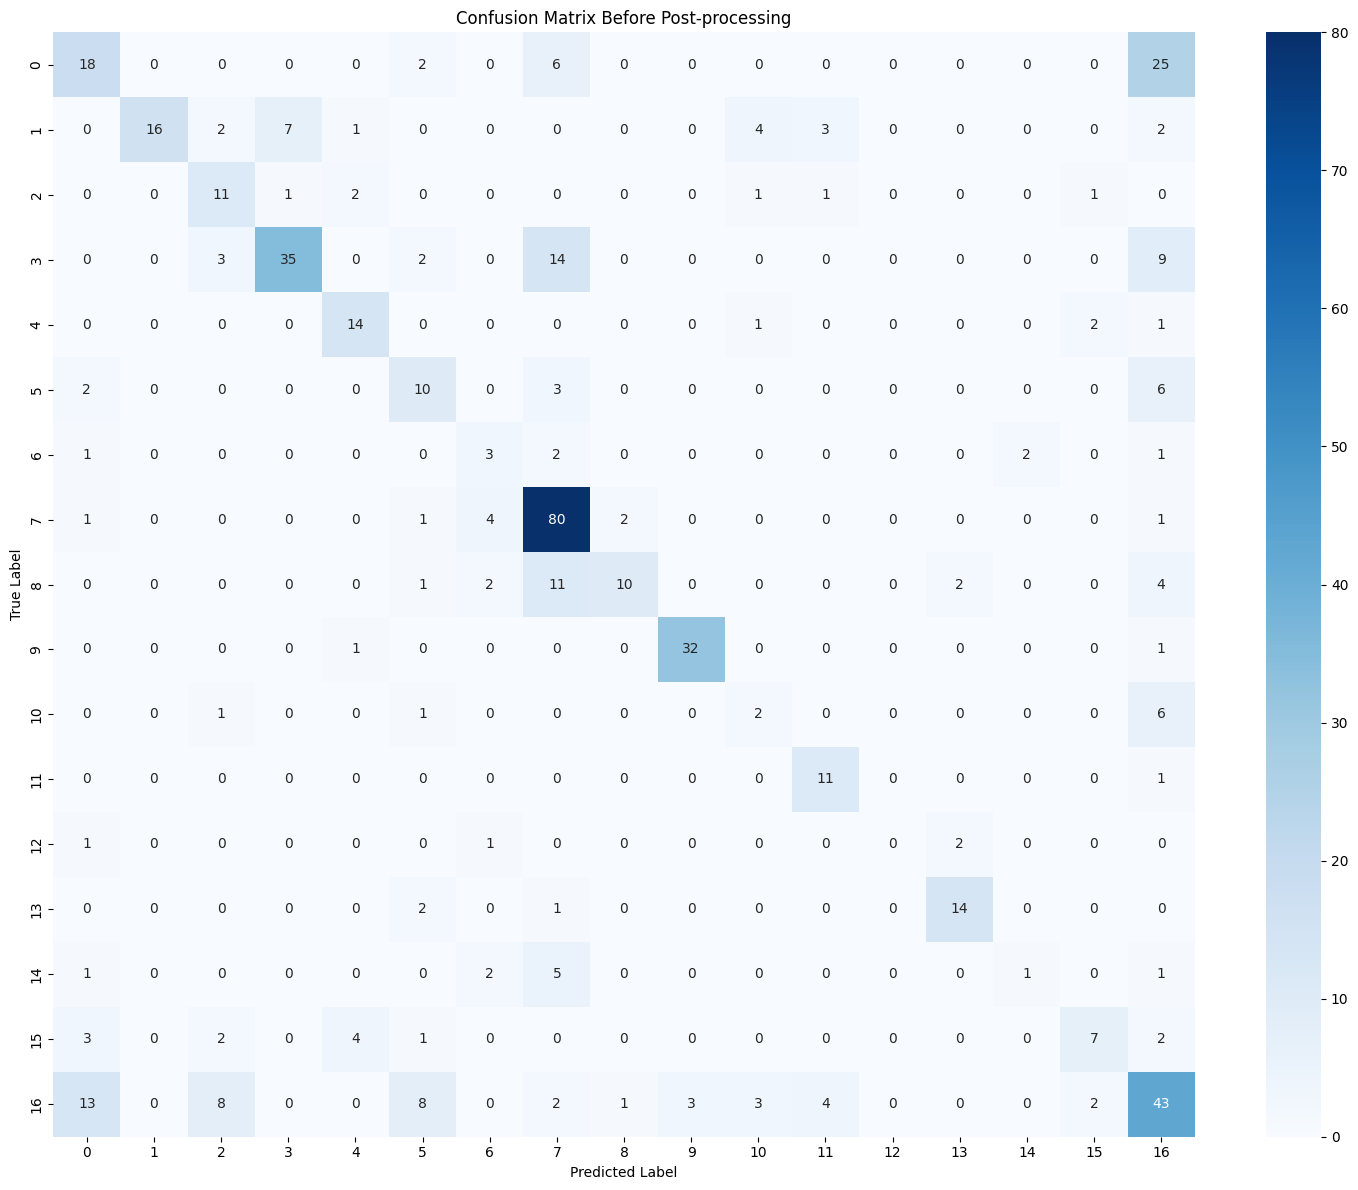

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 获取预测结果
y_pred = model_rf.predict(test_all_features)

# 打印分类报告
print("Classification Report:")
print(classification_report(test_all_labels, y_pred))

# 计算混淆矩阵
cm = confusion_matrix(test_all_labels, y_pred, labels=np.arange(17))  # 确保使用0-16的标签

# 创建更大的图表
plt.figure(figsize=(15, 12))  # 调整为更大的尺寸

# 绘制热力图
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.arange(17),  # 使用0-16的标签
            yticklabels=np.arange(17))

# 设置标题和标签
plt.title("Confusion Matrix Before Post-processing")  # 增加标题和图表的间距
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.35      0.40        51
           1       1.00      0.46      0.63        35
           2       0.41      0.65      0.50        17
           3       0.81      0.56      0.66        63
           4       0.64      0.78      0.70        18
           5       0.36      0.48      0.41        21
           6       0.25      0.33      0.29         9
           7       0.65      0.90      0.75        89
           8       0.77      0.33      0.47        30
           9       0.91      0.94      0.93        34
          10       0.18      0.20      0.19        10
          11       0.58      0.92      0.71        12
          12       0.00      0.00      0.00         4
          13       0.78      0.82      0.80        17
          14       0.33      0.10      0.15        10
          15       0.58      0.37      0.45        19
          16       0.42      0.49      0.45        87

   

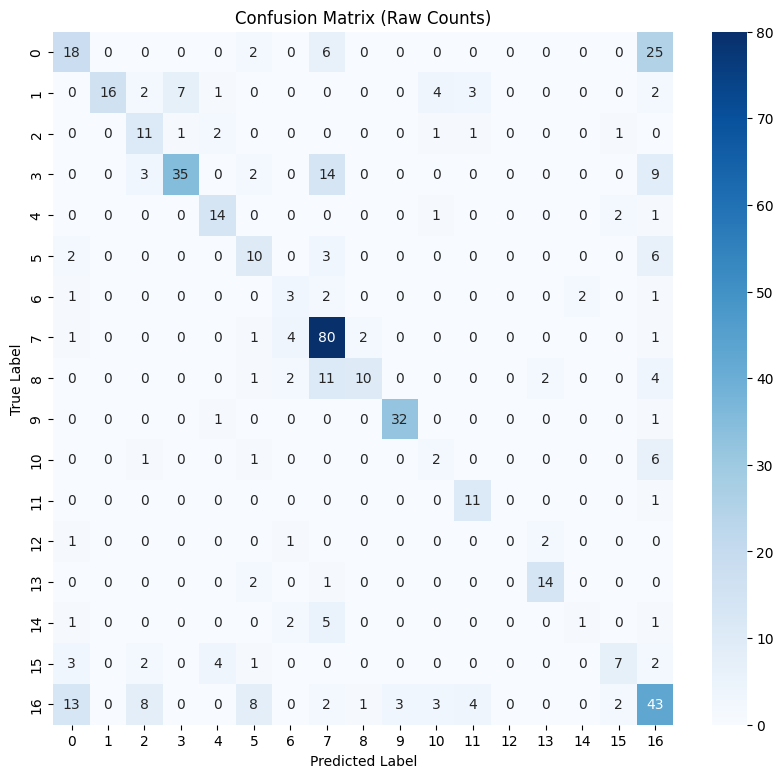

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_pred= model_rf.predict(test_all_features)

print("Classification Report:")
print(classification_report(test_all_labels, y_pred))

cm= confusion_matrix(test_all_labels, y_pred, labels=np.unique(test_all_labels))
plt.figure(figsize=(10,9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(test_all_labels),
            yticklabels=np.unique(test_all_labels))
plt.title("Confusion Matrix (Raw Counts)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

===== Feature Group Importances =====
Baseline                      : 0.4719
Joint Angles                  : 0.0971
Velocity                      : 0.2232
Acceleration                  : 0.0096
Jerk                          : 0.0106
Frequency                     : 0.0392
CumulativeEnergy              : 0.0010
JointDistRatio                : 0.0750
JointAngleRate                : 0.0724

===== Feature Group Importances (Percentage) =====
Baseline                      : 47.19%
Joint Angles                  : 9.71%
Velocity                      : 22.32%
Acceleration                  : 0.96%
Jerk                          : 1.06%
Frequency                     : 3.92%
CumulativeEnergy              : 0.10%
JointDistRatio                : 7.50%
JointAngleRate                : 7.24%


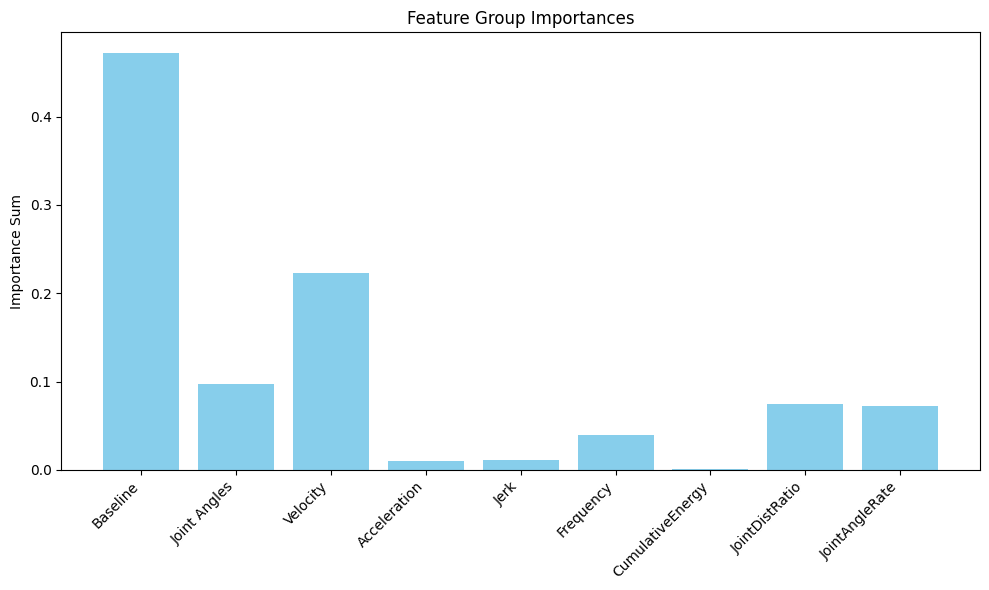

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 假设你的随机森林模型是 model_rf
# 并已完成训练
# feature_importances 的shape应与总特征维度相符
feature_importances = model_rf.feature_importances_

# =========【定义各组长度】=========
# 这里示例共 8 组:
#   1) Skeleton (fw), 2) Angle (fa_), 3) Velocity (fv_) => 合并成 "BasicStats" 3*182 = 546
#   4) Acceleration => 182
#   5) Jerk => 182
#   6) Frequency => 182
#   7) Cumulative Energy => 182
#   8) Distance Ratio => 182
#   9) Angle Rates => 182
# 你可以根据实际特征数量和组合顺序修改
feature_group_lengths = {
    "Baseline": 182,
    "Joint Angles": 182,
    "Velocity": 182,
    "Acceleration": 182,
    "Jerk": 182,
    "Frequency": 182,
    "CumulativeEnergy": 182,
    "JointDistRatio": 182,
    "JointAngleRate": 182
}

group_importances = {}
start_idx = 0
for group_name, length in feature_group_lengths.items():
    end_idx = start_idx + length
    # 求该组区间的贡献度
    importance_sum = np.sum(feature_importances[start_idx:end_idx])
    group_importances[group_name] = importance_sum
    start_idx = end_idx

# =========【打印各组贡献度】=========
print("===== Feature Group Importances =====")
for group_name, imp_value in group_importances.items():
    print(f"{group_name:<30}: {imp_value:.4f}")

# 如果想看各组占比
total_importance = sum(group_importances.values())
print("\n===== Feature Group Importances (Percentage) =====")
for group_name, imp_value in group_importances.items():
    percentage = (imp_value / total_importance)*100 if total_importance > 0 else 0
    print(f"{group_name:<30}: {percentage:.2f}%")

# =========【绘制条形图】=========
df_importance = pd.DataFrame({
    "Group": list(group_importances.keys()),
    "Importance": list(group_importances.values())
})

plt.figure(figsize=(10,6))
plt.bar(df_importance["Group"], df_importance["Importance"], color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.title("Feature Group Importances")
plt.ylabel("Importance Sum")
plt.tight_layout()
plt.show()


===== Advanced Feature Analysis =====

1. Computing SHAP values...


<Figure size 1200x800 with 0 Axes>

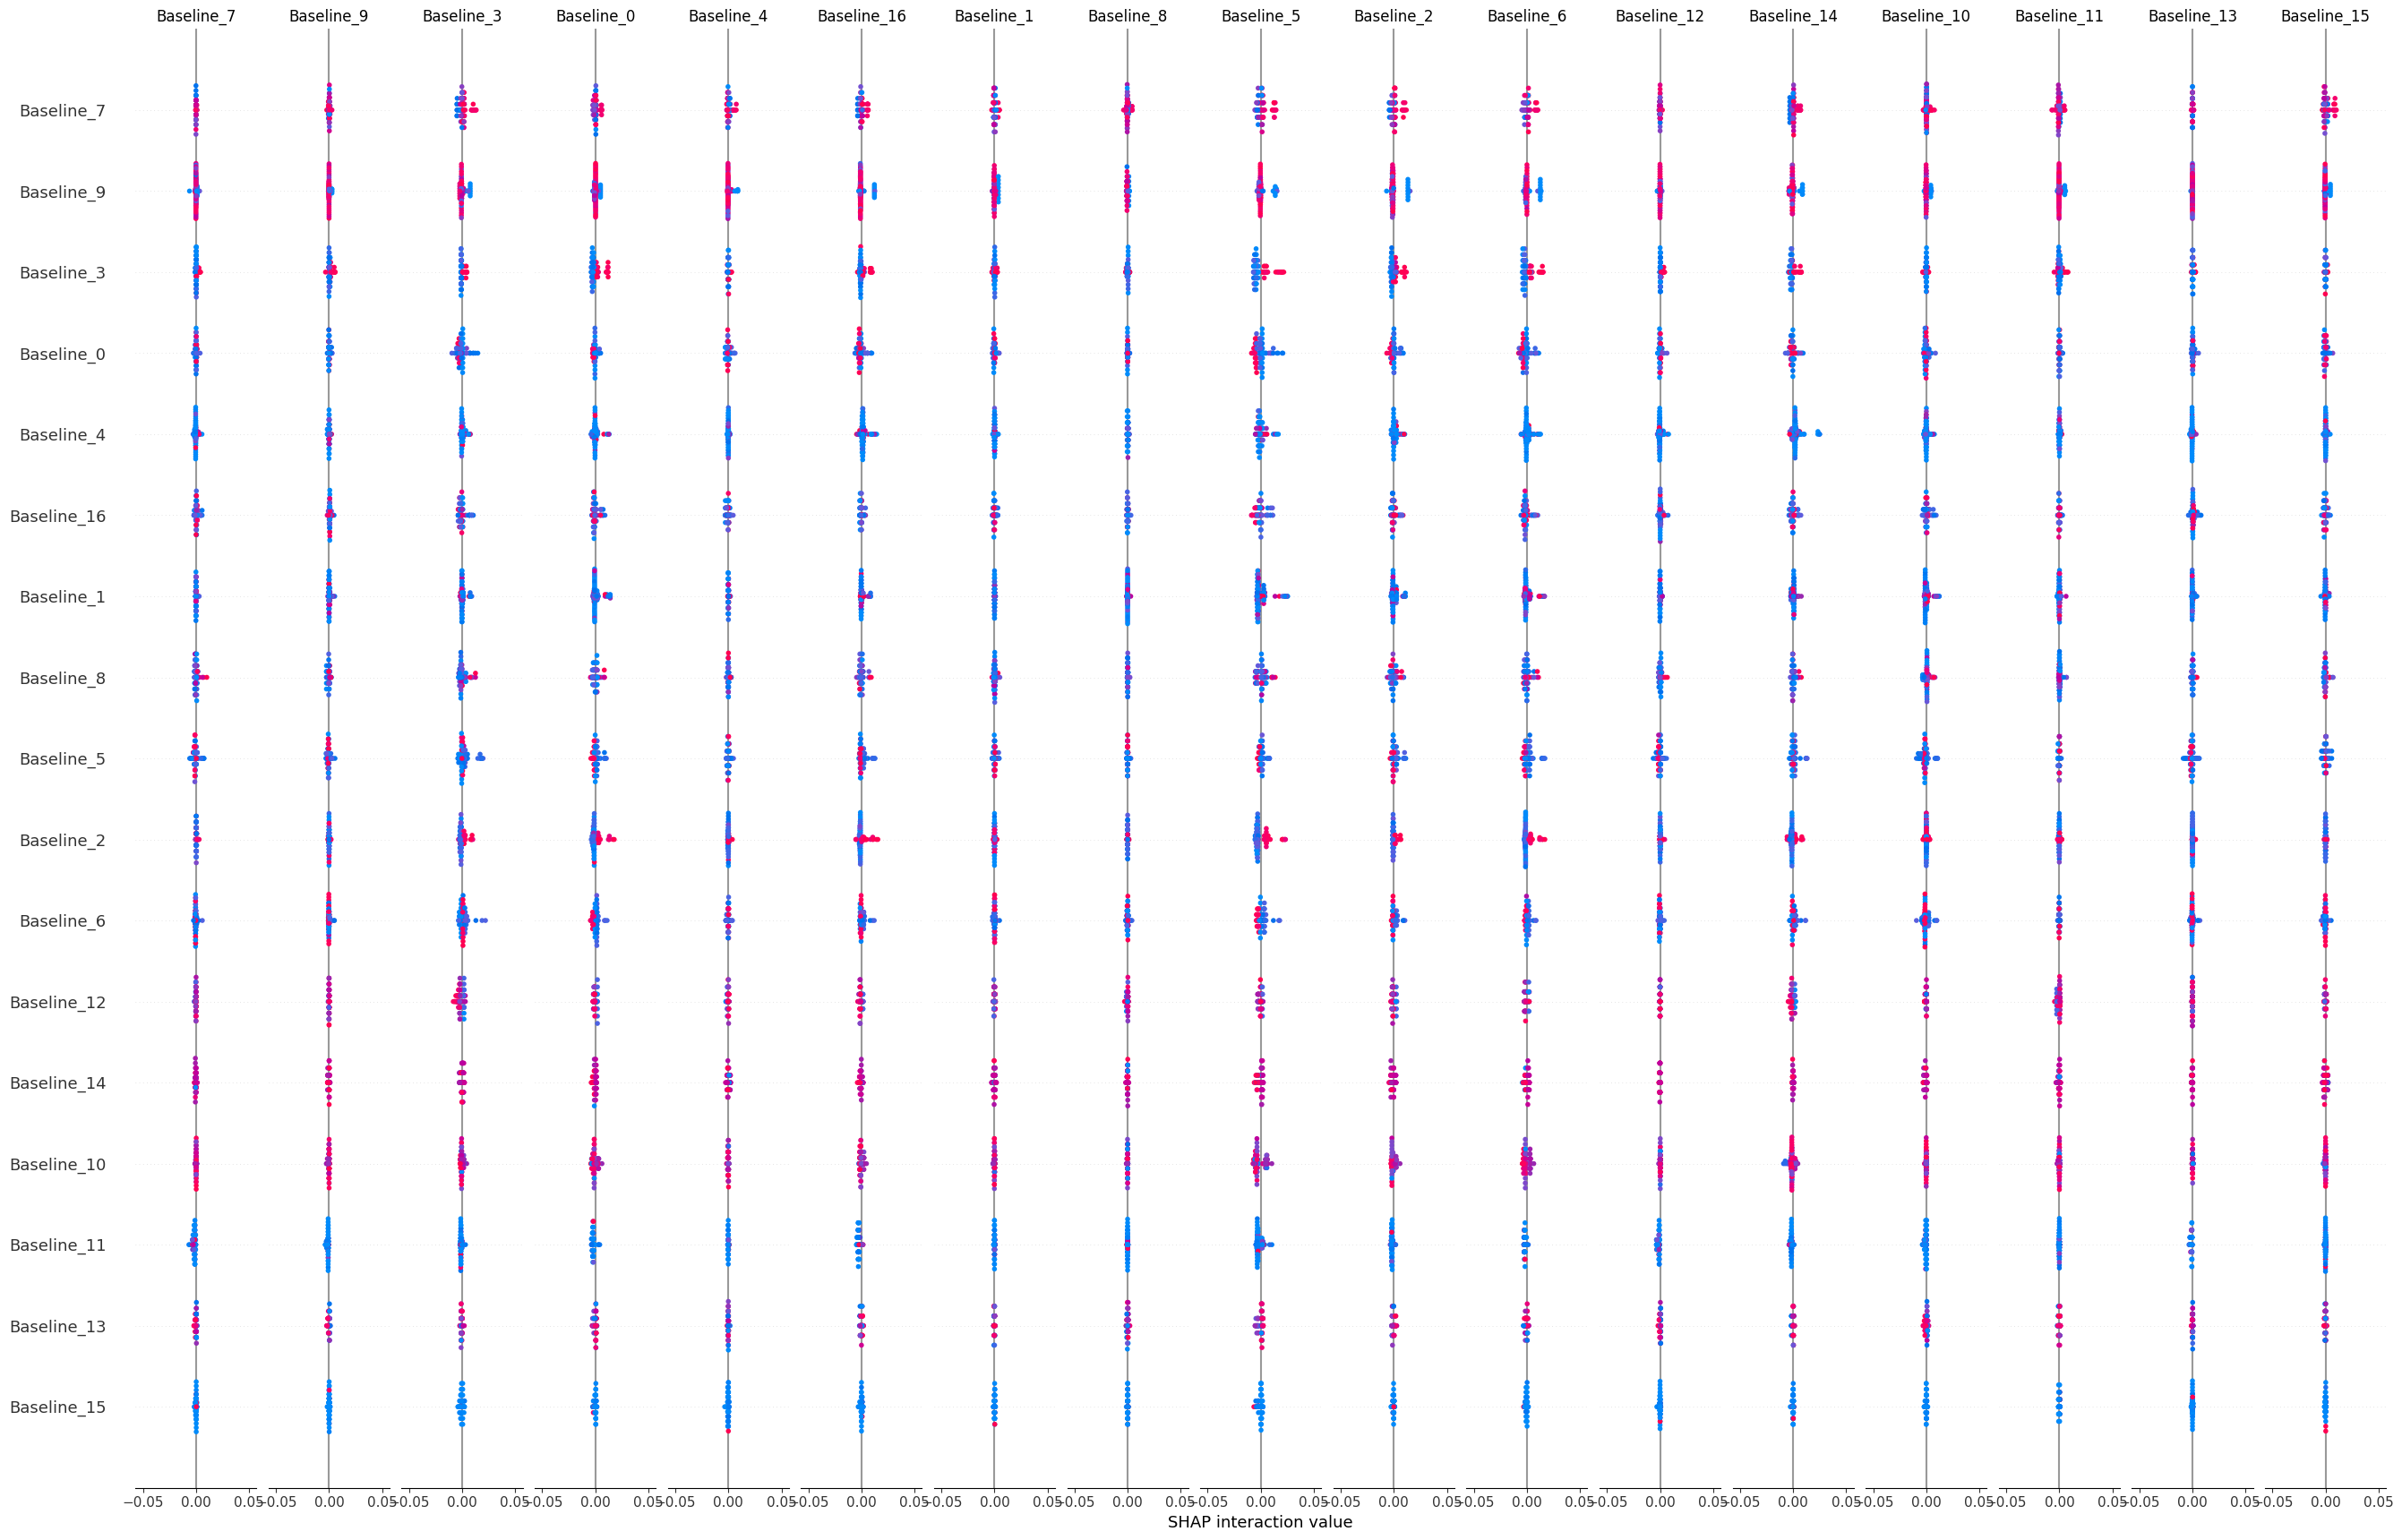

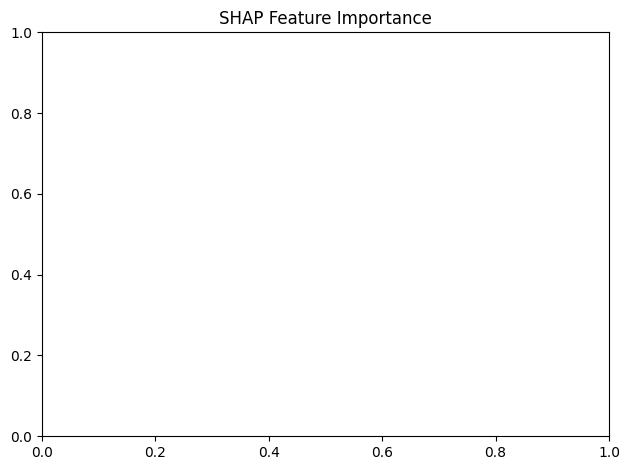


2. Creating Partial Dependence Analysis...


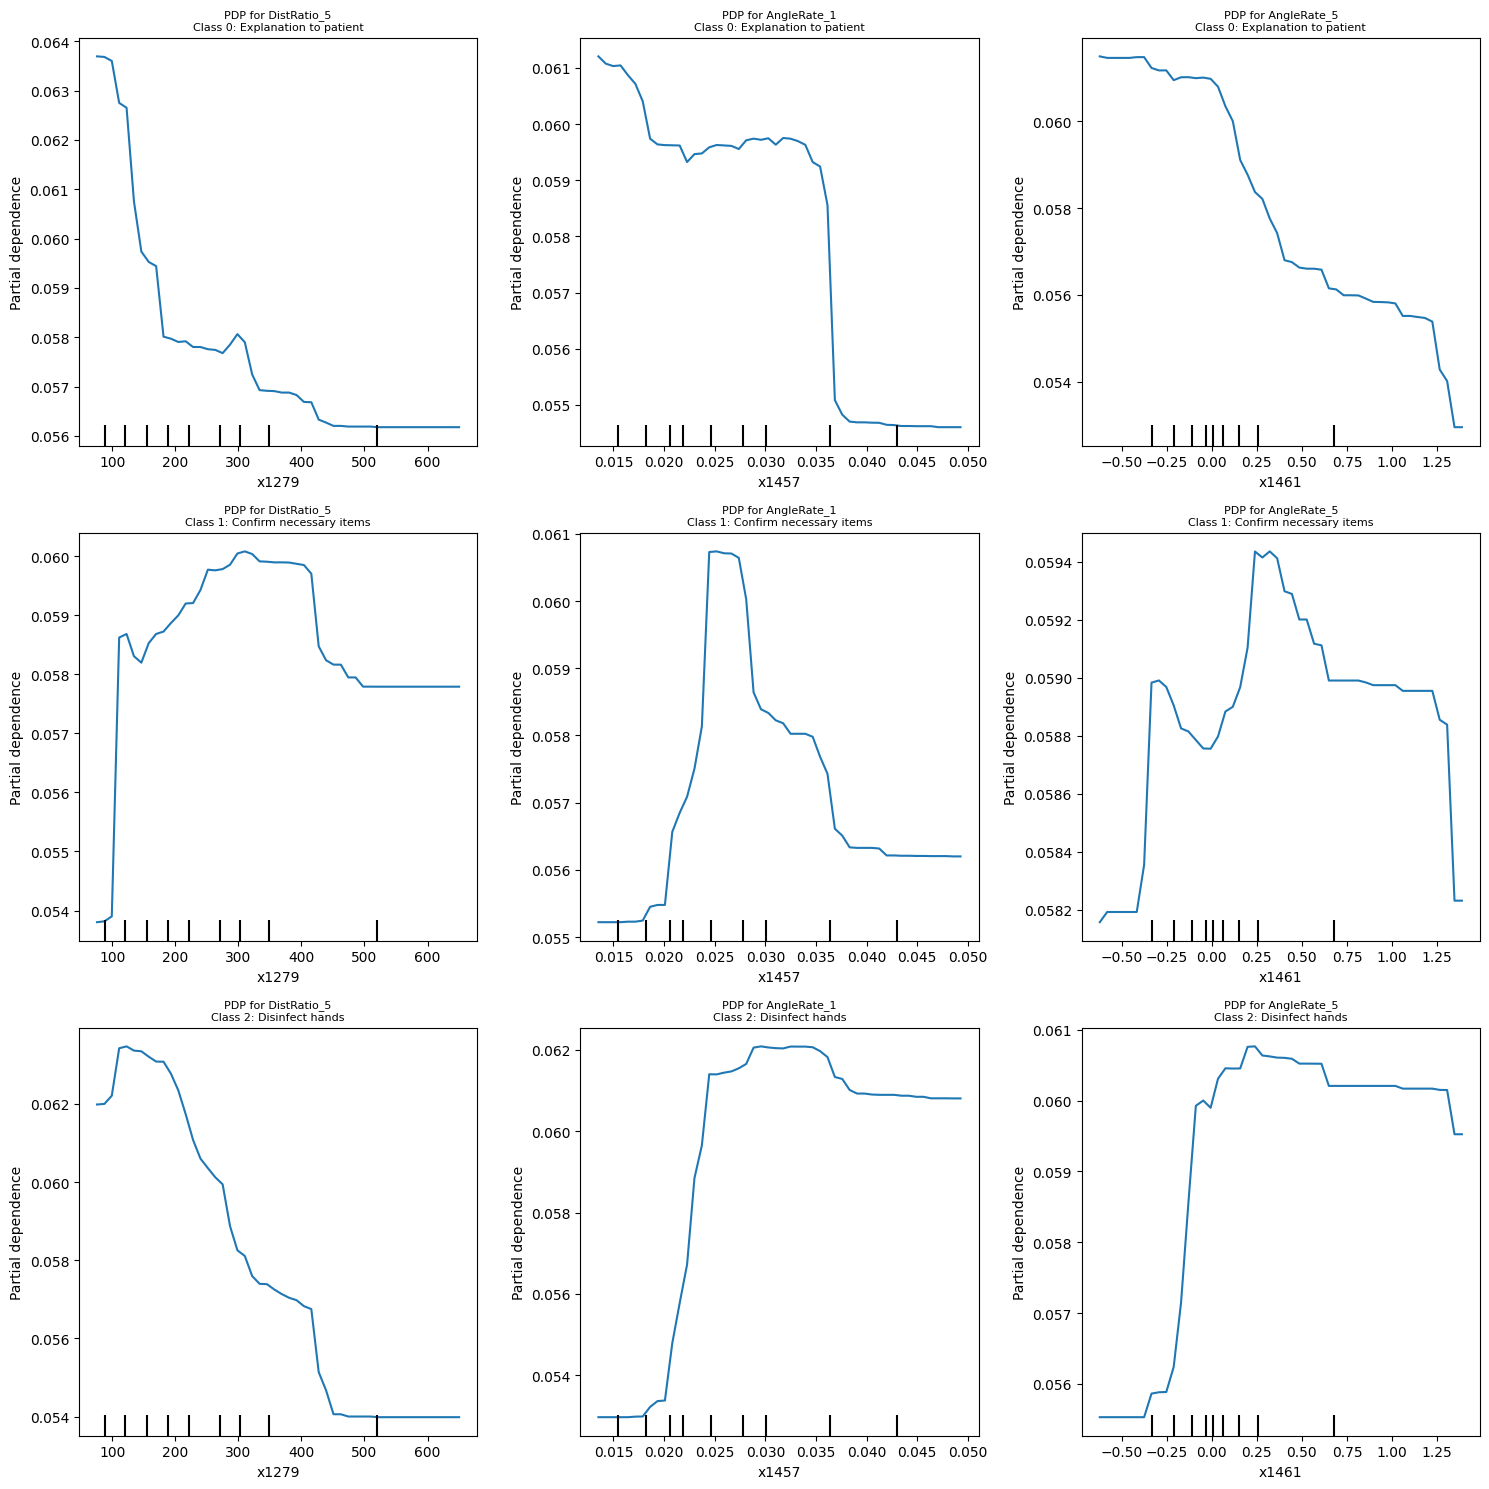


3. Computing Permutation Importance...

Top 20 Features by Permutation Importance:
             Feature  Importance_Mean  Importance_Std
1456     AngleRate_0         0.018251        0.003089
1461     AngleRate_5         0.016160        0.001753
1278     DistRatio_4         0.012357        0.003427
1458     AngleRate_2         0.011217        0.004028
1459     AngleRate_3         0.009506        0.002249
220   JointAngles_38         0.008935        0.001217
1277     DistRatio_3         0.008175        0.006075
52       Baseline_52         0.007034        0.001911
1279     DistRatio_5         0.006844        0.007708
40       Baseline_40         0.006654        0.002852
1460     AngleRate_4         0.006654        0.002586
135     Baseline_135         0.006464        0.002281
128     Baseline_128         0.005323        0.002375
199   JointAngles_17         0.004943        0.002117
79       Baseline_79         0.004943        0.001261
9         Baseline_9         0.004943        0.00257

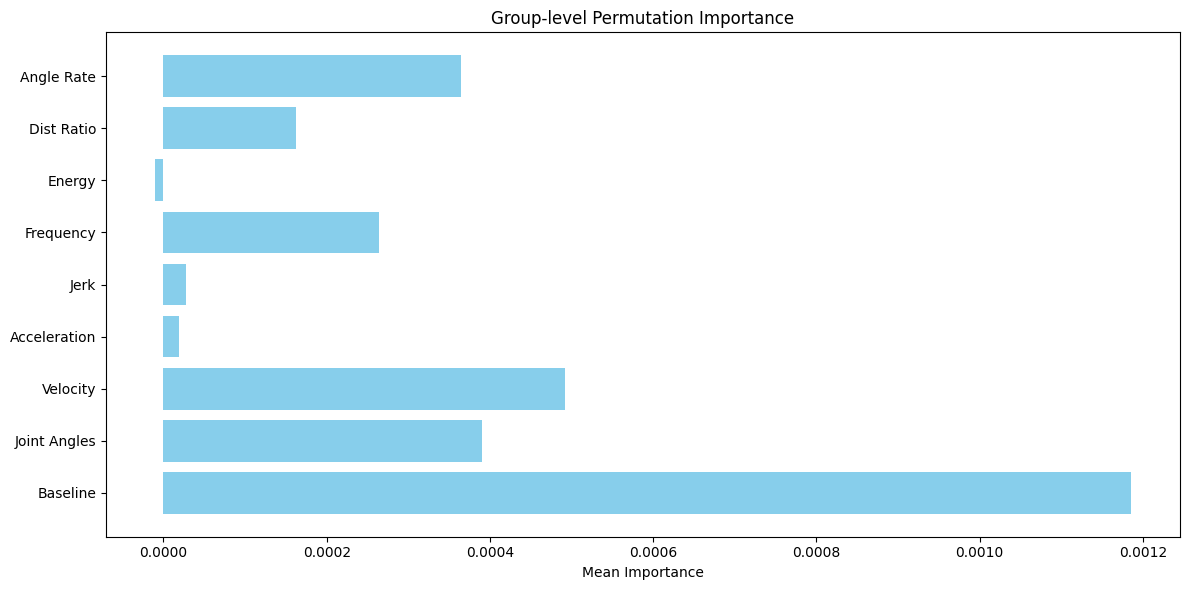


4. Computing Feature Correlations...


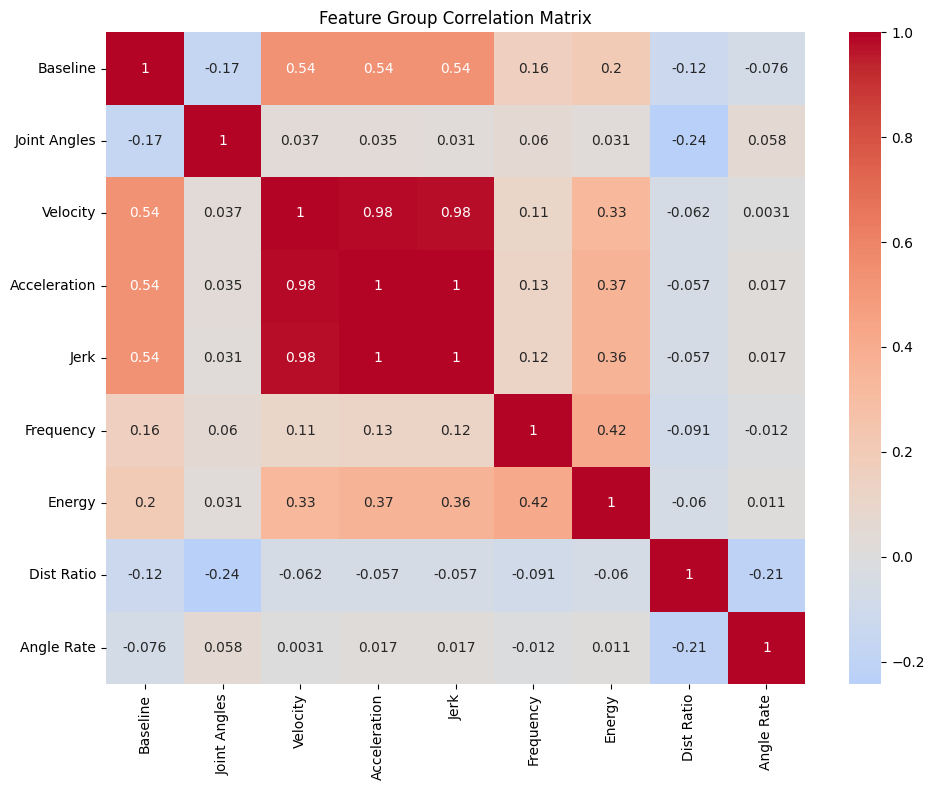

In [ ]:
print("\n===== Advanced Feature Analysis =====")

# 1. SHAP Values Analysis
print("\n1. Computing SHAP values...")
!pip install shap --quiet
import shap

# 创建SHAP解释器
explainer = shap.TreeExplainer(model_rf)

# 为了计算效率，选择一个子集
n_samples = min(100, len(X_train_resampled))
X_train_subset = X_train_resampled[:n_samples]

# 创建特征名称列表 - 使用原始特征命名
features_baseline = [f"Baseline_{i}" for i in range(182)]
features_angles = [f"JointAngles_{i}" for i in range(182)]
features_velocity = [f"Velocity_{i}" for i in range(182)]
features_accel = [f"Acceleration_{i}" for i in range(182)]
features_jerk = [f"Jerk_{i}" for i in range(182)]
features_freq = [f"Frequency_{i}" for i in range(182)]
features_energy = [f"Energy_{i}" for i in range(182)]
features_dist_ratio = [f"DistRatio_{i}" for i in range(182)]
features_angle_rate = [f"AngleRate_{i}" for i in range(182)]

feature_names = (features_baseline + features_angles + features_velocity +
                features_accel + features_jerk + features_freq +
                features_energy + features_dist_ratio + features_angle_rate)

# 计算SHAP值
shap_values = explainer.shap_values(X_train_subset)

# SHAP Summary Plot
plt.figure(figsize=(12, 8))
if isinstance(shap_values, list):
    # 多分类情况
    shap.summary_plot(shap_values[0], pd.DataFrame(X_train_subset, columns=feature_names),
                     plot_type="bar",
                     max_display=20)
else:
    # 二分类情况
    shap.summary_plot(shap_values, pd.DataFrame(X_train_subset, columns=feature_names),
                     plot_type="bar",
                     max_display=20)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

# 2. Partial Dependence Analysis
print("\n2. Creating Partial Dependence Analysis...")
from sklearn.inspection import PartialDependenceDisplay

# 获取最重要的特征索引
feature_importances = pd.Series(model_rf.feature_importances_, index=feature_names)
top_features_idx = [-importance for importance in model_rf.feature_importances_]
top_3_features = np.argsort(top_features_idx)[:3]

# 选择几个重要的类别进行分析
important_classes = [0, 1, 2]  # 这里选择前三个类别
n_cols = len(top_3_features)
n_rows = len(important_classes)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
for row, target_class in enumerate(important_classes):
    for col, feature_idx in enumerate(top_3_features):
        feature_name = feature_names[feature_idx]
        display = PartialDependenceDisplay.from_estimator(
            model_rf,
            X_train_resampled,
            [feature_idx],
            target=target_class,
            ax=axes[row, col] if n_rows > 1 else axes[col],
            kind='average',
            grid_resolution=50
        )
        title = f'PDP for {feature_name}\nClass {target_class}: {list(action_mapping.keys())[list(action_mapping.values()).index(target_class)]}'
        if n_rows > 1:
            axes[row, col].set_title(title, fontsize=8)
        else:
            axes[col].set_title(title, fontsize=8)

plt.tight_layout()
plt.show()

# 3. Permutation Feature Importance
print("\n3. Computing Permutation Importance...")
from sklearn.inspection import permutation_importance

# 计算排列重要性
perm_importance = permutation_importance(model_rf, test_all_features, test_all_labels,
                                       n_repeats=10, random_state=42)

# 创建DataFrame展示结果
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Mean': perm_importance.importances_mean,
    'Importance_Std': perm_importance.importances_std
}).sort_values(by="Importance_Mean", ascending=False)

# 展示前20个最重要的特征
print("\nTop 20 Features by Permutation Importance:")
print(perm_importance_df.head(20))

# 可视化排列重要性 (按特征组)
plt.figure(figsize=(12, 6))
group_perm_importance = {
    'Baseline': np.mean(perm_importance.importances_mean[:182]),
    'Joint Angles': np.mean(perm_importance.importances_mean[182:364]),
    'Velocity': np.mean(perm_importance.importances_mean[364:546]),
    'Acceleration': np.mean(perm_importance.importances_mean[546:728]),
    'Jerk': np.mean(perm_importance.importances_mean[728:910]),
    'Frequency': np.mean(perm_importance.importances_mean[910:1092]),
    'Energy': np.mean(perm_importance.importances_mean[1092:1274]),
    'Dist Ratio': np.mean(perm_importance.importances_mean[1274:1456]),
    'Angle Rate': np.mean(perm_importance.importances_mean[1456:])
}

plt.barh(list(group_perm_importance.keys()),
         list(group_perm_importance.values()),
         color='skyblue')
plt.title("Group-level Permutation Importance")
plt.xlabel("Mean Importance")
plt.tight_layout()
plt.show()

# 4. 相关性分析
print("\n4. Computing Feature Correlations...")
# 计算特征组之间的相关性
group_features = {
    'Baseline': np.mean(X_train_resampled[:, :182], axis=1),
    'Joint Angles': np.mean(X_train_resampled[:, 182:364], axis=1),
    'Velocity': np.mean(X_train_resampled[:, 364:546], axis=1),
    'Acceleration': np.mean(X_train_resampled[:, 546:728], axis=1),
    'Jerk': np.mean(X_train_resampled[:, 728:910], axis=1),
    'Frequency': np.mean(X_train_resampled[:, 910:1092], axis=1),
    'Energy': np.mean(X_train_resampled[:, 1092:1274], axis=1),
    'Dist Ratio': np.mean(X_train_resampled[:, 1274:1456], axis=1),
    'Angle Rate': np.mean(X_train_resampled[:, 1456:], axis=1)
}

correlation_df = pd.DataFrame(group_features)
correlation_matrix = correlation_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Feature Group Correlation Matrix")
plt.tight_layout()
plt.show()

In [17]:
def post_process_predictions(pred_labels, pred_probs, threshold=0.6):
    """
    根据后处理规则调整预测结果，考虑模型的预测概率。

    参数：
    - pred_labels: 模型的预测标签列表或数组。
    - pred_probs: 模型的预测概率数组，形状为 (样本数, 类别数)。
    - threshold: 置信度阈值，低于该值的预测将被考虑进行后处理。

    返回：
    - adjusted_preds: 经过调整的预测标签列表。
    """
    import numpy as np

    adjusted_preds = pred_labels.copy()
    adjusted_preds = np.array(adjusted_preds)
    pred_probs = np.array(pred_probs)

    # 获取预测序列的长度
    seq_len = len(adjusted_preds)

    # 获取模型预测的置信度（最大概率值）
    confidences = np.max(pred_probs, axis=1)

    # 规则 1：修正动作 6（Open the gastrostomy cap）
    for i in range(1, seq_len):
        if adjusted_preds[i] == 7 and confidences[i] < threshold:
            if adjusted_preds[i - 1] != 6:
                adjusted_preds[i - 1] = 6

    # 规则 2：修正动作 12（Close the clamp）
    for i in range(1, seq_len):
        if adjusted_preds[i] == 13 and confidences[i] < threshold:
            if adjusted_preds[i - 1] != 12:
                adjusted_preds[i - 1] = 12

    # 规则 3：修正动作 14（Close the gastrostomy cap）
    for i in range(1, seq_len - 1):
        if adjusted_preds[i] == 13 and adjusted_preds[i + 1] == 7 and confidences[i + 1] < threshold:
            if i + 2 < seq_len and adjusted_preds[i + 2] != 14:  # 添加边界检查
                adjusted_preds[i + 2] = 14

    # 规则 4：修正动作 10（Removal of gloves）
    for i in range(seq_len - 1):
        if adjusted_preds[i] == 15 and confidences[i] < threshold:
            if adjusted_preds[i + 1] != 10:
                adjusted_preds[i + 1] = 10

    return adjusted_preds.tolist()

# 获取模型预测概率和预测标签
pred_probs = model_rf.predict_proba(test_all_features)
y_predict = model_rf.predict(test_all_features)

# 应用后处理规则
adjusted_preds = post_process_predictions(y_predict, pred_probs, threshold=0.6)

# 打印处理前后的分类报告
from sklearn.metrics import classification_report

print("The result before：")
print(classification_report(test_all_labels, y_predict))

print("\nThe result after：")
print(classification_report(test_all_labels, adjusted_preds))

The result before：
              precision    recall  f1-score   support

           0       0.45      0.35      0.40        51
           1       1.00      0.46      0.63        35
           2       0.41      0.65      0.50        17
           3       0.81      0.56      0.66        63
           4       0.64      0.78      0.70        18
           5       0.36      0.48      0.41        21
           6       0.25      0.33      0.29         9
           7       0.65      0.90      0.75        89
           8       0.77      0.33      0.47        30
           9       0.91      0.94      0.93        34
          10       0.18      0.20      0.19        10
          11       0.58      0.92      0.71        12
          12       0.00      0.00      0.00         4
          13       0.78      0.82      0.80        17
          14       0.33      0.10      0.15        10
          15       0.58      0.37      0.45        19
          16       0.42      0.49      0.45        87

    acc

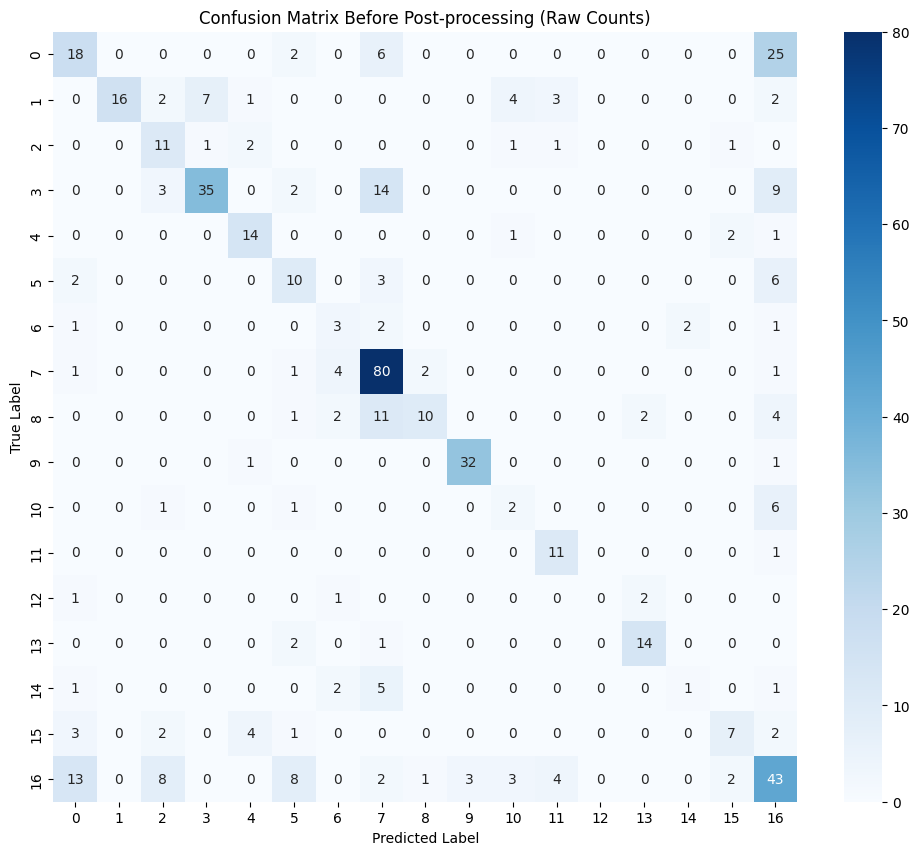

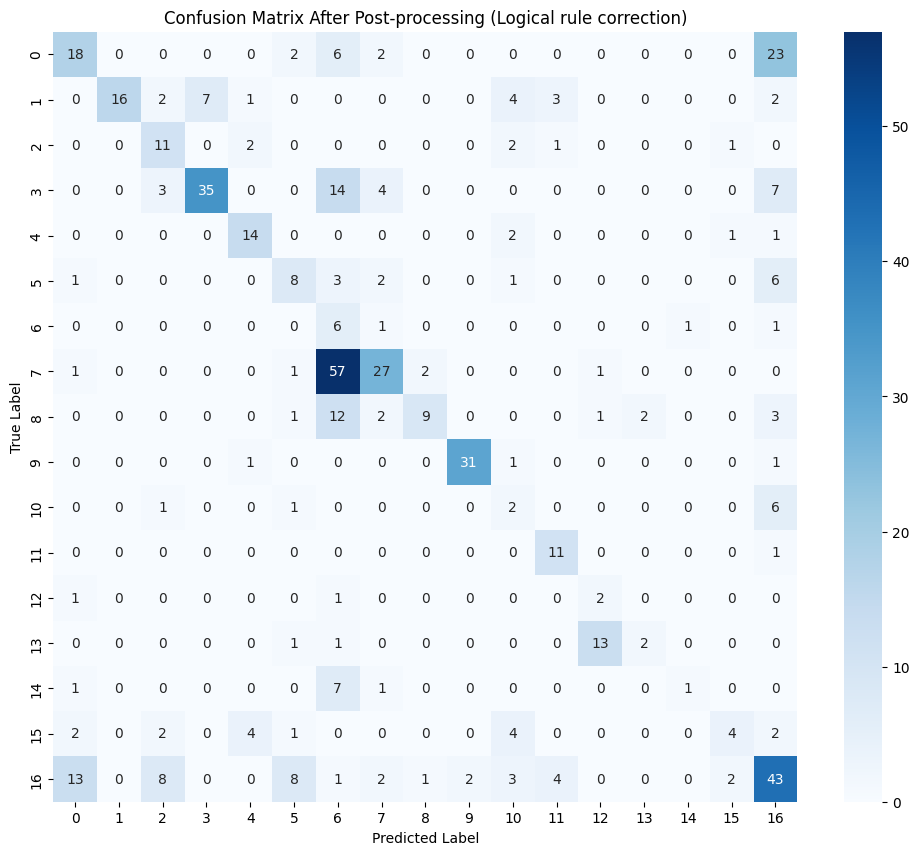

In [19]:
# 计算并显示混淆矩阵
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 处理前的混淆矩阵
cm_before = confusion_matrix(test_all_labels, y_predict)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_before, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix Before Post-processing (Raw Counts)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 处理后的混淆矩阵
cm_after = confusion_matrix(test_all_labels, adjusted_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_after, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix After Post-processing (Logical rule correction)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [18]:
# 计算每个动作的平均持续时间
def calculate_avg_durations(ann_data, fs=FS):
    durations = {}
    for ann_df in ann_data:
        for _, row in ann_df.iterrows():
            action = row['activityID']
            duration = row['stop_time'] - row['start_time']
            if action not in durations:
                durations[action] = []
            durations[action].append(duration)

    avg_durations = {}
    for action, times in durations.items():
        avg_durations[action] = np.mean(times)

    return avg_durations

# 计算训练集的平均持续时间
train_avg_duration = calculate_avg_durations(all_ann_data)


===== Post-processing Analysis =====
Comparison of Actual and Predicted Labels:
    True Labels  Pred Labels
0            16            2
1             1            2
2             1            2
3             1            3
4             1            4
5             1           10
6             1           10
7             1           10
8            16           10
9            16           16
10            4           10
11            4           16
12           16           16
13           16           16
14           16           16
15           16           16
16            4           15
17            4           15
18            4            4
19            4            4

1. Dynamic Window Smoothing...

Dynamic Smoothing Results:
              precision    recall  f1-score   support

           0       0.49      0.41      0.45        51
           1       0.91      0.57      0.70        35
           2       0.29      0.35      0.32        17
           3       0.78      0.62

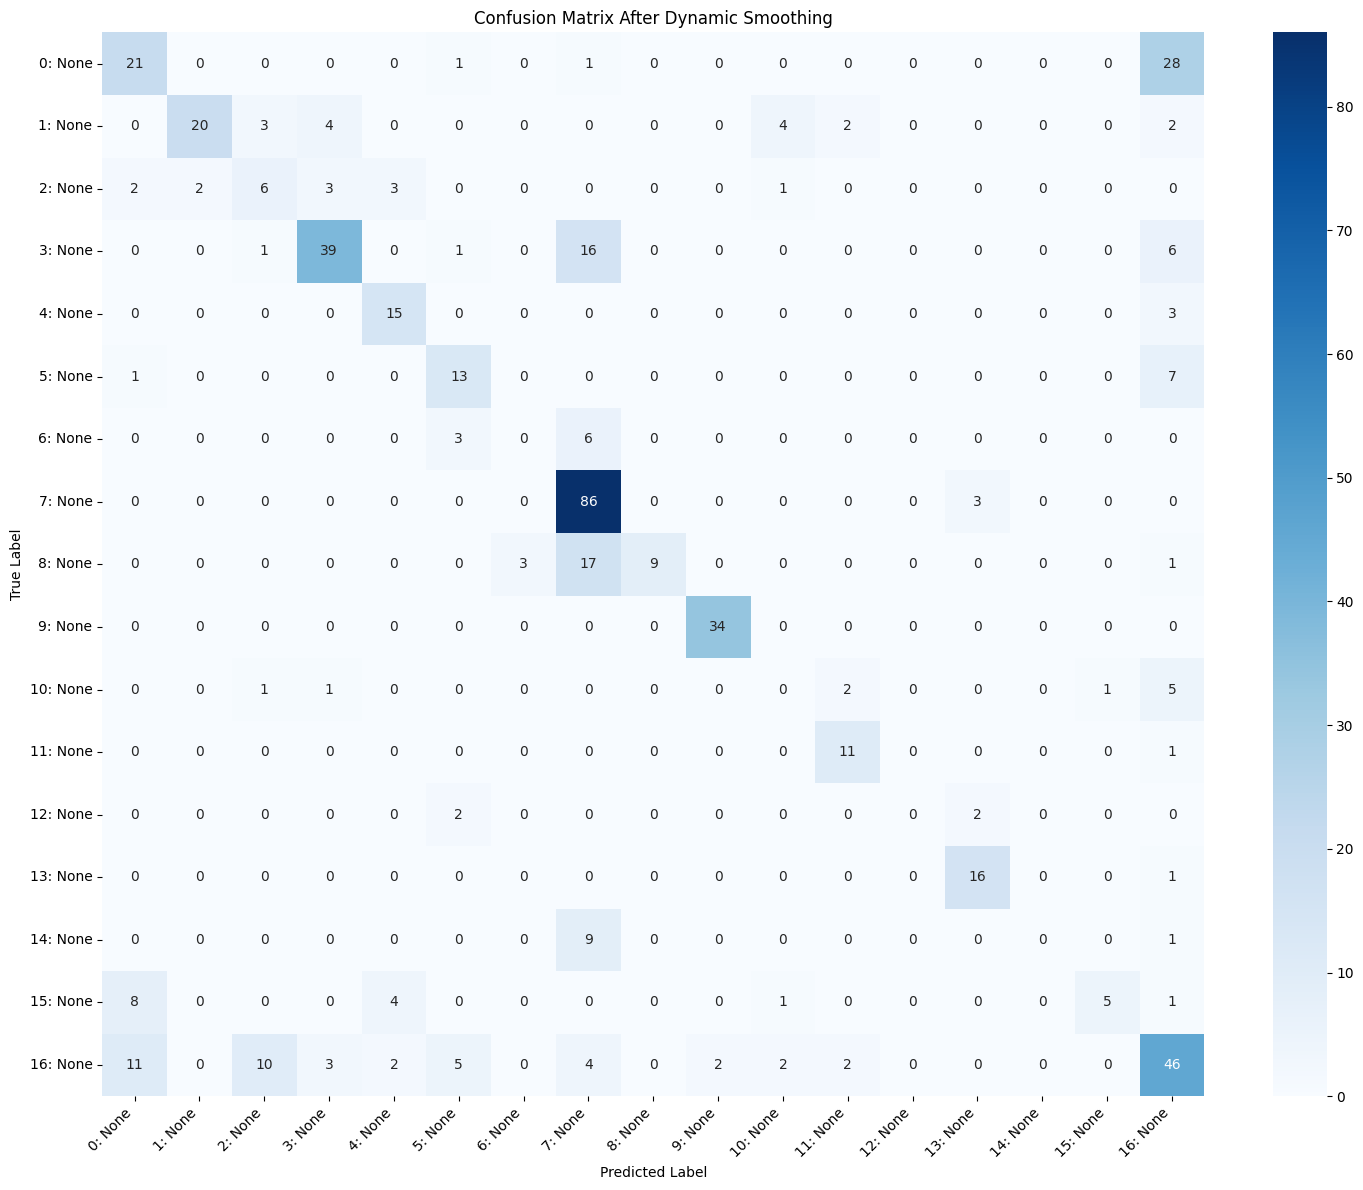


2. Short-Action Priority Smoothing...

Short-Action Priority Smoothing Results:
              precision    recall  f1-score   support

           0       0.49      0.41      0.45        51
           1       0.91      0.57      0.70        35
           2       0.30      0.35      0.32        17
           3       0.78      0.62      0.69        63
           4       0.62      0.83      0.71        18
           5       0.59      0.62      0.60        21
           6       0.20      0.33      0.25         9
           7       0.65      0.92      0.76        89
           8       1.00      0.30      0.46        30
           9       0.94      1.00      0.97        34
          10       0.14      0.20      0.17        10
          11       0.85      0.92      0.88        12
          12       0.00      0.00      0.00         4
          13       0.76      0.94      0.84        17
          14       0.33      0.10      0.15        10
          15       0.83      0.26      0.40        19


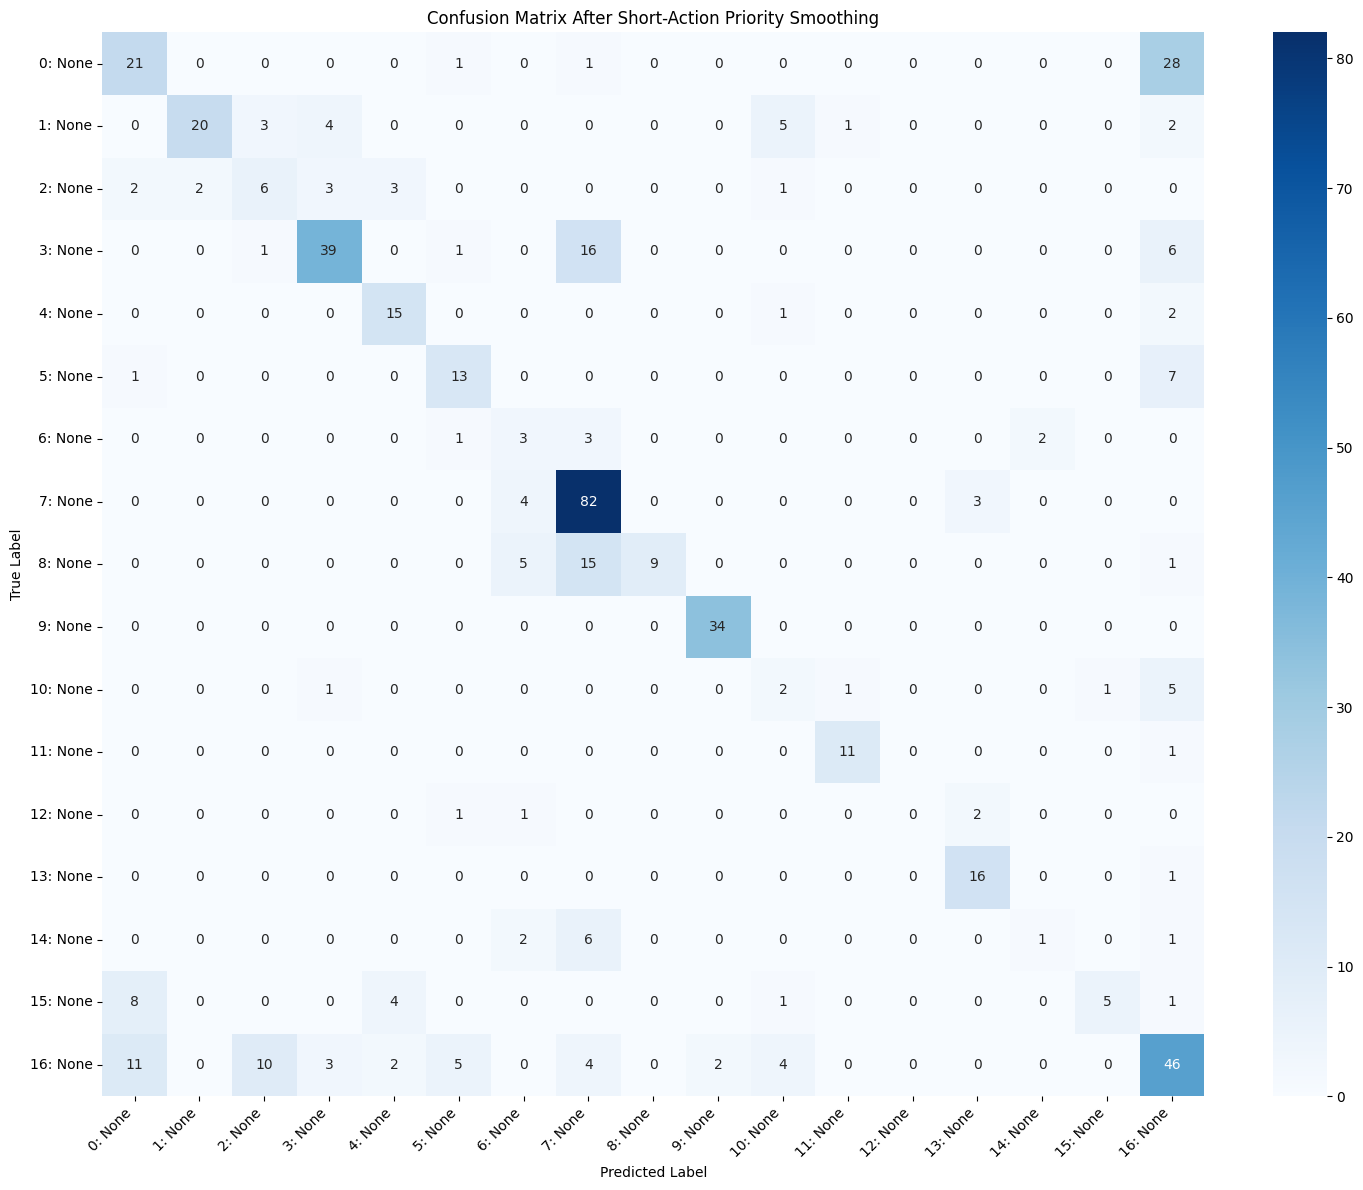

In [19]:
# =========【后处理：预测结果分析】=========
print("\n===== Post-processing Analysis =====")

# 保存预测结果
results_df = pd.DataFrame({
    "True Labels": test_all_labels,
    "Pred Labels": y_pred
})

print("Comparison of Actual and Predicted Labels:")
print(results_df.head(20))
results_df.to_csv("predictions_result.csv", index=False)

# =========【1. 动态窗口平滑】=========
print("\n1. Dynamic Window Smoothing...")

def dynamic_smooth_predictions(preds, avg_durations, fs, min_window=3, max_window=9):
    smoothed_preds = preds.copy()
    best_window_sizes = {}

    for action, avg_duration in avg_durations.items():
        window_size = max(min(int(avg_duration * fs), max_window), min_window)
        if window_size % 2 == 0:
            window_size += 1

        best_window_sizes[action] = window_size

        indices = np.where(preds == action)[0]
        if len(indices) > 0:
            padded_preds = np.pad(preds, (window_size // 2, window_size // 2), mode='edge')
            for i in indices:
                window = padded_preds[i:i + window_size]
                most_common = np.bincount(window).argmax()
                smoothed_preds[i] = most_common

    return smoothed_preds, best_window_sizes

# 应用动态平滑
dynamic_smoothed_preds, best_window_sizes = dynamic_smooth_predictions(
    y_pred, avg_durations=train_avg_duration, fs=FS
)

print("\nDynamic Smoothing Results:")
print(classification_report(test_all_labels, dynamic_smoothed_preds))
print("Accuracy after dynamic smoothing:", accuracy_score(test_all_labels, dynamic_smoothed_preds))

# 绘制动态平滑后的混淆矩阵
plt.figure(figsize=(15, 12))
cm_dynamic = confusion_matrix(test_all_labels, dynamic_smoothed_preds, labels=np.arange(17))
sns.heatmap(cm_dynamic, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"{i}: {action_mapping.get(i)}" for i in range(17)],
            yticklabels=[f"{i}: {action_mapping.get(i)}" for i in range(17)])
plt.title("Confusion Matrix After Dynamic Smoothing")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# =========【2. 短时间动作优先平滑】=========
print("\n2. Short-Action Priority Smoothing...")

def smooth_predictions_short_priority(preds, window_size=9, short_actions=None, short_action_min_length=3):
    if short_actions is None:
        short_actions = []

    smoothed_preds = []
    half_window = window_size // 2
    padded_preds = np.pad(preds, (half_window, half_window), mode='edge')

    for i in range(len(preds)):
        window = padded_preds[i:i + window_size]
        most_common = np.bincount(window).argmax()

        if preds[i] in short_actions:
            count = 1
            # 向前检查
            for j in range(i - 1, max(-1, i - short_action_min_length), -1):
                if preds[j] != preds[i]:
                    break
                count += 1
            # 向后检查
            for j in range(i + 1, min(len(preds), i + short_action_min_length)):
                if preds[j] != preds[i]:
                    break
                count += 1

            if count < short_action_min_length:
                most_common = preds[i]

        smoothed_preds.append(most_common)

    return np.array(smoothed_preds)

# 应用短时间动作优先平滑
short_actions = [6, 10, 12, 14]  # 需要优化的短时间动作
smoothed_preds_short = smooth_predictions_short_priority(
    y_pred,
    window_size=9,
    short_actions=short_actions,
    short_action_min_length=3
)

print("\nShort-Action Priority Smoothing Results:")
print(classification_report(test_all_labels, smoothed_preds_short))
print("Accuracy after short-action priority smoothing:",
      accuracy_score(test_all_labels, smoothed_preds_short))

# 绘制短时间动作优先平滑后的混淆矩阵
plt.figure(figsize=(15, 12))
cm_short = confusion_matrix(test_all_labels, smoothed_preds_short, labels=np.arange(17))
sns.heatmap(cm_short, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"{i}: {action_mapping.get(i)}" for i in range(17)],
            yticklabels=[f"{i}: {action_mapping.get(i)}" for i in range(17)])
plt.title("Confusion Matrix After Short-Action Priority Smoothing")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


=== Dynamic Window Smoothing Results ===


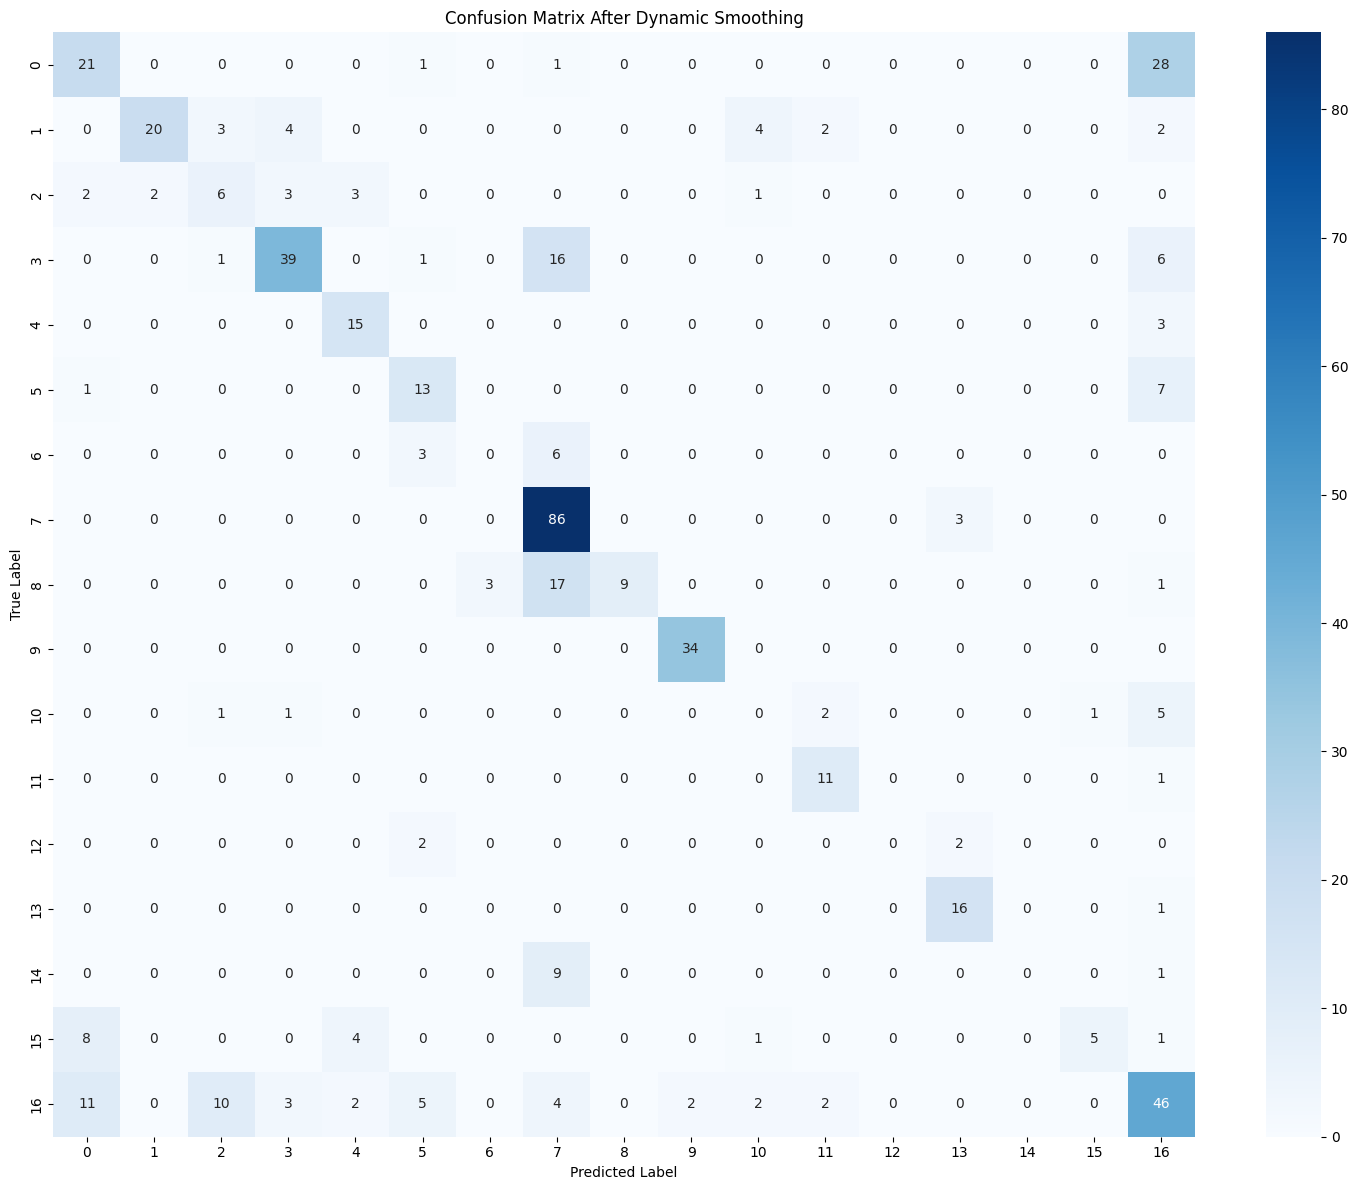


=== Short-Action Priority Smoothing Results ===


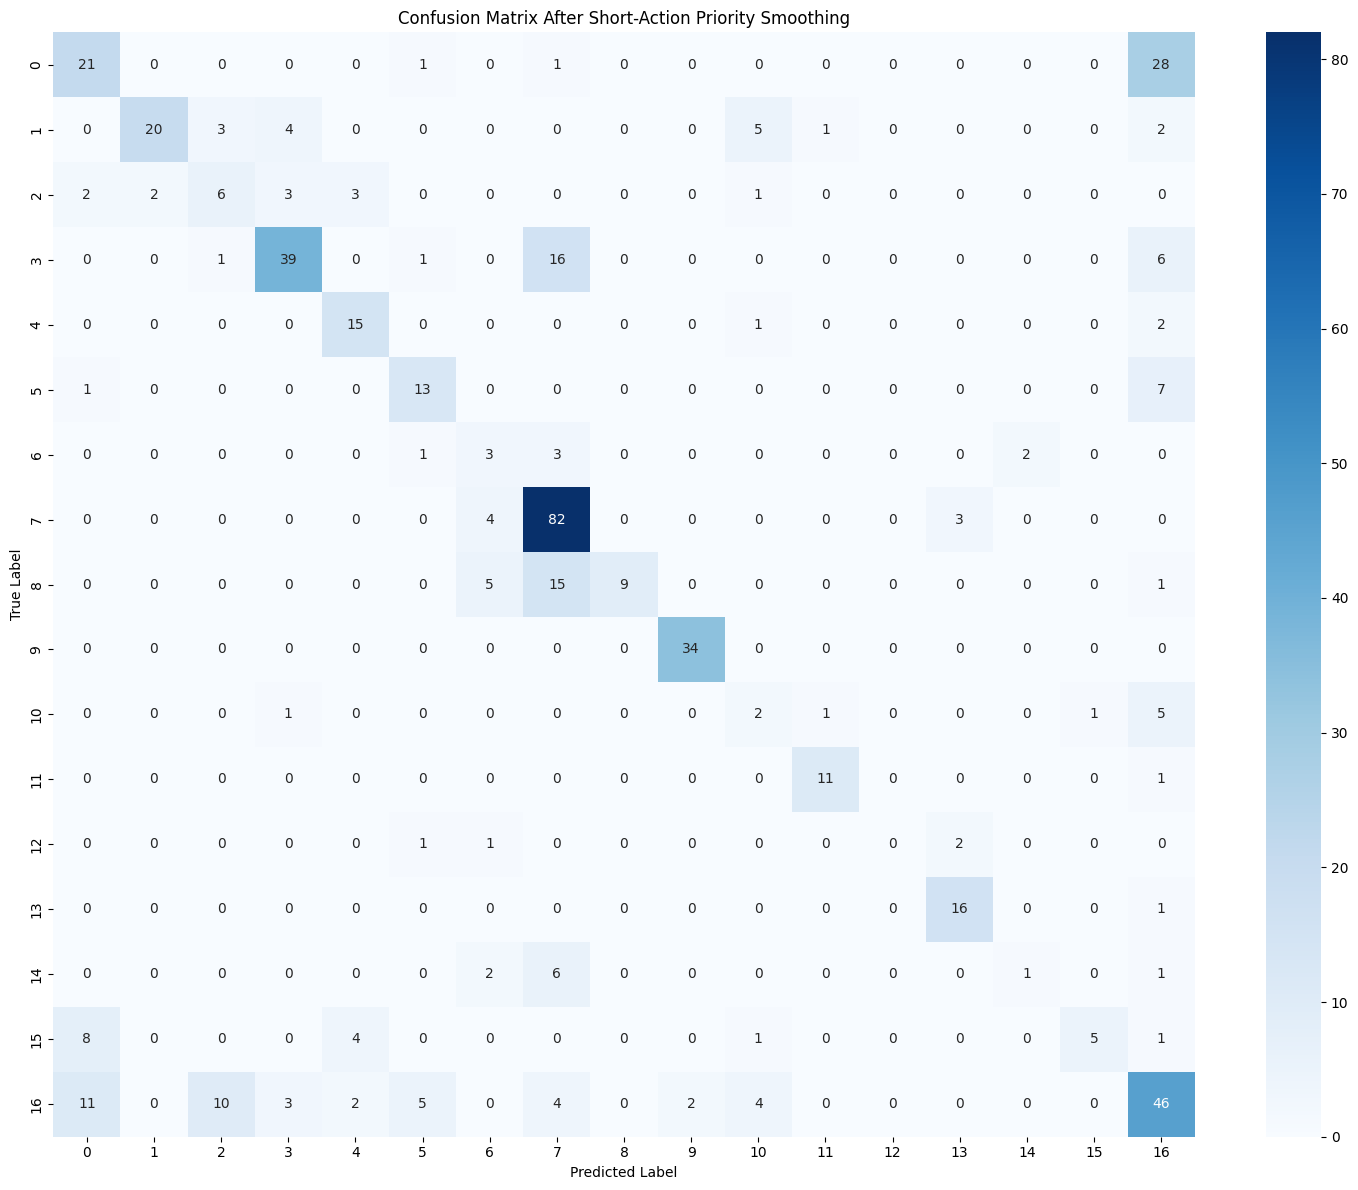

In [20]:
# =========【后处理：动态窗口平滑】=========
print("\n=== Dynamic Window Smoothing Results ===")

# 绘制动态平滑后的混淆矩阵
plt.figure(figsize=(15, 12))
cm_dynamic = confusion_matrix(test_all_labels, dynamic_smoothed_preds, labels=np.arange(17))
sns.heatmap(cm_dynamic, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.arange(17),  # 只显示数字标签
            yticklabels=np.arange(17))  # 只显示数字标签
plt.title("Confusion Matrix After Dynamic Smoothing")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# =========【后处理：短时间动作优先平滑】=========
print("\n=== Short-Action Priority Smoothing Results ===")

# 绘制短时间动作优先平滑后的混淆矩阵
plt.figure(figsize=(15, 12))
cm_short = confusion_matrix(test_all_labels, smoothed_preds_short, labels=np.arange(17))
sns.heatmap(cm_short, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.arange(17),  # 只显示数字标签
            yticklabels=np.arange(17))  # 只显示数字标签
plt.title("Confusion Matrix After Short-Action Priority Smoothing")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


===== Individual Test ID Analysis =====


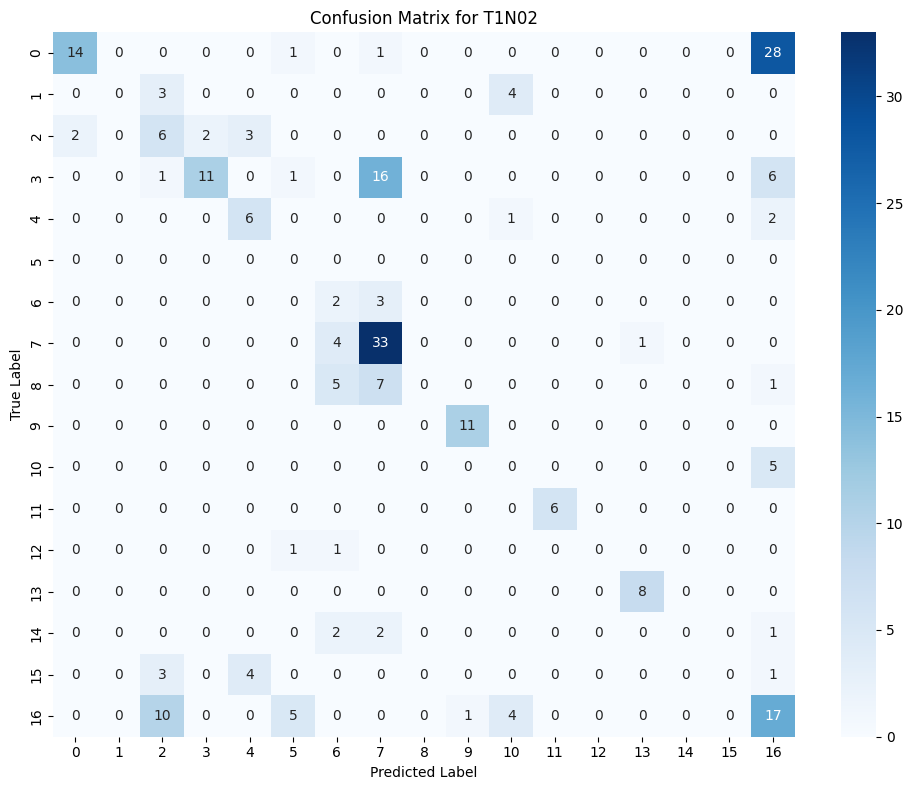

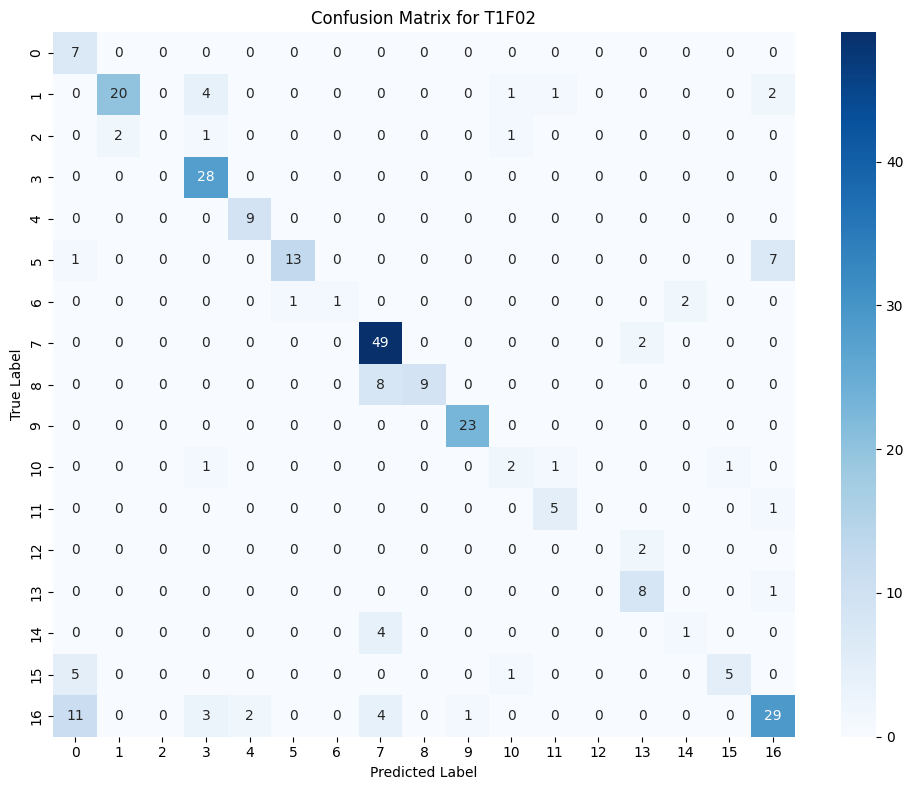


Results by Test ID:
File       Accuracy     F1-score  

T1N02      0.46         0.44      
T1F02      0.75         0.73      

TOTAL      0.60         0.58      



In [25]:
# =========【各测试ID的结果分析】=========
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

print("\n===== Individual Test ID Analysis =====")

# 存储每个测试ID的结果
test_results = {}

# 对每个测试ID分别处理
for test_id, kp_df, ann_df in zip(TEST_IDS, test_all_kp_data, test_all_ann_data):
    # 提取该测试ID的特征和标签
    feats, labs = extract_all_features(kp_df, ann_df, desired_len=182)

    if len(feats) > 0:
        # 预测
        y_pred = model_rf.predict(feats)

        # 应用短时间动作优先平滑
        smoothed_preds = smooth_predictions_short_priority(
            y_pred,
            window_size=9,
            short_actions=[6, 10, 12, 14],
            short_action_min_length=3
        )

        # 计算指标并四舍五入到两位小数
        acc = round(accuracy_score(labs, smoothed_preds), 2)
        f1 = round(f1_score(labs, smoothed_preds, average="weighted"), 2)

        # 存储结果
        test_results[test_id] = {
            "Accuracy": acc,
            "F1-score": f1
        }

        # 输出该测试ID的混淆矩阵
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(labs, smoothed_preds, labels=np.arange(17))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=np.arange(17),
                   yticklabels=np.arange(17))
        plt.title(f"Confusion Matrix for {test_id}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()

# 创建结果表格
results_df = pd.DataFrame(test_results).T
results_df.index.name = 'File'
results_df.loc['TOTAL'] = results_df.mean().round(2)  # 平均值也四舍五入到两位小数

# 显示结果
print("\nResults by Test ID:")
print(f"\033[1m{'File':<8}   {'Accuracy':<10}   {'F1-score':<10}\033[0m")
print()
for idx, row in results_df.iterrows():
    if idx == 'TOTAL':
        print()
        print(f"\033[1m{idx:<8}   {row['Accuracy']:<10.2f}   {row['F1-score']:<10.2f}\033[0m")
    else:
        print(f"{idx:<8}   {row['Accuracy']:<10.2f}   {row['F1-score']:<10.2f}")
print()